<center><b><u>Enrichment Analysis - sgRNA<center><b><u>

Our platform allows for screening rates of up to one million cells per run, with a minimum rate of 100,000 cells. To optimize this process, an enrichment strategy has been developed.

In a CRISPR perturbation screen, the Geometric Distribution is the most commonly used sgRNA sequencing distribution, with an emphasis on evenly distributes sgRNAs across a gene or set of genes. However, the Negative Binomial Distribution is also used and provides more accurate measurement of perturbation by emphasizing the number of times a gene target is hit. 

The ```Simulate``` module simulates AIPS by definingthe  the sgRNA pool for a given gene using the ```lookupString``` parameter. It uses the published crispri sgRNA data (Horlbeck et al) and a Negative Binomial distribution with parameters n and p to determine the number of effective (successful) sgRNA in the pool , as shown in the Python library [pymc](https://www.pymc.io/welcome.html). The argument ```tpRatio``` indicates the number of effective target sgRNA in the pool. It is known that approximately 0.2 to 0.4 of the sgRNA targeting a particular gene are effective, according to the paper by Daley et al. 

- Max A Horlbeck, Luke A Gilbert, Jacqueline E Villalta, Britt Adamson, Ryan A Pak, Yuwen Chen, Alexander P Fields, Chong Yon Park, Jacob E Corn, Martin Kampmann, Jonathan S Weissman (2016) Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation eLife 5:e19760 https://doi.org/10.7554/eLife.19760

- Daley, T., Lin, Z., Lin, X. et al. CRISPhieRmix: a hierarchical mixture model for CRISPR pooled screens. Genome Biol 19, 159 (2018). https://doi.org/10.1186/s13059-018-1538-6



```python
from AIPyS import AIPS_simulate as sim
# filtered list of sgRNA data from the reference library for the sub library h4
dfH4 = pd.read_csv('dfH4.csv')
```

The command ```simulation``` defines the false positives limits and the number of observations per acquisition, which is drawn from a normal distribution.

```python
orig, Q1, Q2 = sim.Simulate(df = dfH4 ,lookupString =  'PEX' ,tpRatio = 20, n= 10 , p = 0.1).simulation(
                            FalseLimits  = (0.1,0.5), ObservationNum = (70,20))
```
This function returns three data frames: ```orig``` contains the original read counts, ```Q1``` contains the read counts of the sgRNAs not selected during acquisition, and ```Q2``` contains the read counts of the selected hits the "activated" sample.

In [1]:
self.df['activeSg'] = False
indexPexActiveArray = self.df.loc[random.sample(indexTarget, self.tpRatio)].index.tolist()
self.df.loc[indexPexActiveArray, 'activeSg'] = True
# list of sgRNA which are true
TruePositiveSGs = tuple(self.df.loc[indexPexActiveArray, 'sgID'].to_list())

NameError: name 'self' is not defined

Enrichment analysis was performed by comparing the activated simulated data (Q2) with the non-activated simulated data (Q1). Mapping of the read counts was done according to the unique Gene names, and the perturbation effects were calculated by dividing the log count data of Q2 by that of Q1.

```python
from AIPyS import mapSgRNA 
# filtered list of sgRNA data from the reference library for the sub library h4
pathIn = r'F:\HAB_2\PrinzScreen\AIPS_simulation\AIPS_simulation\data'
Q2 = pd.read_csv(os.path.join(pathIn,'h4_1_45tpGuide_Q2.csv'))
Q1 = pd.read_csv(os.path.join(pathIn,'h4_1_45tpGuide_Q1.csv'))
# unique

uniqueSgRNA = np.unique(Q2.sgID.values)

# The mapping of unique sgRNA to the SIM was performed using the module mapsgrna

dictDF = mapSgRNA(df1 = Q1, df2 = Q2)

# Make dictionary mapping reads to unique sgRNA

df_dict = dictDF.mapping(uniqueSgRNA = uniqueSgRNA)

# data frame contain logFC and z-score logFC

df = dictDF.dataFrameFinal(df_dict)
```

## Simulation Data

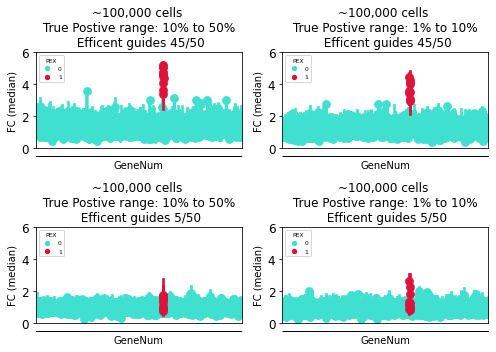

In [17]:
# {code-cell} ipython3
# :tags: [hide-input]
import numpy as np
import os
import pandas as pd
import matplotlib as plt
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
import glob
import re
import warnings
warnings.filterwarnings('ignore')
Data_path = r"F:\HAB_2\PrinzScreen\AIPS_simulation\AIPS_simulation\data\20230331\*.csv"
files = glob.glob(Data_path)
files = [files[0],files[4],files[5],files[6],files[7],files[8],files[9],files[10],files[11],files[1],files[2],files[3]]
def TableTollGen(fileName,index = [0,1,2]):
    df2 = pd.read_csv(fileName[index[0]])
    df4 = pd.read_csv(fileName[index[0]])
    df5 = pd.read_csv(fileName[index[0]])

    df2 = df2.loc[:,['Gene','sgRNA','reads_ctrl', 'reads_activate']]
    df2 = df2.rename(columns={'reads_ctrl': "1ctrl", "reads_activate": "4activate"})

    df4 = df4.loc[:,['Gene','sgRNA','reads_ctrl', 'reads_activate']]
    df4 = df4.rename(columns={'reads_ctrl': "2ctrl", "reads_activate": "5activate"})

    df5 = df5.loc[:,['Gene','sgRNA','reads_ctrl', 'reads_activate']]
    df5 = df5.rename(columns={'reads_ctrl': "3ctrl", "reads_activate": "6activate"})

    df = pd.merge(df4,df5, on='sgRNA')
    df = df.drop('Gene_y', 1) # drop duplicate info

    df = pd.merge(df,df2, on='sgRNA')
    df = df.drop('Gene', 1) # drop duplicate info
    # remove non
    df = df.drop(index=df.loc[df.Gene_x.str.contains('non'),:].index)
    df = pd.DataFrame({'Gene':df.Gene_x,'1ctrl':df['1ctrl'],'2ctrl':df['2ctrl'],
                 '3ctrl':df['3ctrl'],'4activate':df['4activate'],'5activate':df['5activate'],
                  '6activate':df['6activate']})
    dfTall = pd.melt(df,id_vars = ['Gene'], value_vars=['1ctrl', '2ctrl','3ctrl',
                                                     '4activate', '5activate', '6activate'])
    dfTall['Condition'] = 1
    dfTall.loc[dfTall.variable.str.contains('ctrl'),'Condition'] = 0
    idxCtrl = dfTall.loc[dfTall.Condition == 0,:].index
    idxActive = dfTall.loc[dfTall.Condition == 1,:].index
    dfTall_oneHot = pd.get_dummies(dfTall, columns = ['Condition','variable','Gene'])

    CtrlValue_Target = dfTall.loc[idxCtrl,'value'].to_numpy()
    ActiveValue_Target = dfTall.loc[idxActive,'value'].to_numpy()
    
    #median Normalization
    CtrlValue_Target = CtrlValue_Target/np.median(CtrlValue_Target)
    ActiveValue_Target = ActiveValue_Target/np.median(ActiveValue_Target)
    
    GeneToNUmber = {key:i for i, key in enumerate(np.unique(dfTall.loc[idxCtrl,'Gene'].to_numpy()))}
    GeneNames = dfTall.loc[idxCtrl,'Gene'].to_list()
    NumberToGene = [GeneToNUmber[gene] for gene in GeneNames]
    dfSum = pd.DataFrame({'Gene':dfTall.loc[idxCtrl,'Gene'].to_numpy(),'GeneNum':NumberToGene,
                         'FC (median)':ActiveValue_Target/CtrlValue_Target})
    
    
    
    dfSum['PEX'] = 0
    dfSum.loc[dfSum.Gene.str.contains('PEX'),'PEX'] =1
    return dfSum
df_HighEf_lowFP = TableTollGen(files,index = [0,1,2])
df_HighEf_HigFP = TableTollGen(files,index = [3,4,5])
df_LowEf_lowFP = TableTollGen(files,index = [6,7,8])
df_LowEf_HigFP = TableTollGen(files,index = [9,10,11])

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns

title = ["~100,000 cells \n True Postive range: 10% to 50% \n Efficent guides 45/50",
        "~100,000 cells \n True Postive range: 1% to 10% \n Efficent guides 45/50",
        "~100,000 cells \n True Postive range: 10% to 50% \n Efficent guides 5/50",
        "~100,000 cells \n True Postive range: 1% to 10% \n Efficent guides 5/50"]


fig, axs = plt.subplots(2, 2, figsize=(7, 5))
color_dict = {0: to_rgba('cornflowerblue', 1),
              1: to_rgba('crimson', 0.7),
              0: to_rgba('turquoise', 0.4)}
# axs[0,0].xlabel(None)
# axs[0,1].xlabel(None)
# axs[1,0].xlabel(None)
# axs[1,1].xlabel(None)
axs[0,0].tick_params(axis='y', which='major', labelsize=12)
axs[0,1].tick_params(axis='y', which='major', labelsize=12)
axs[1,0].tick_params(axis='y', which='major', labelsize=12)
axs[1,1].tick_params(axis='y', which='major', labelsize=12)
axs[0,0].tick_params(axis='x', which='major', labelsize=0)
axs[0,1].tick_params(axis='x', which='major', labelsize=0)
axs[1,0].tick_params(axis='x', which='major', labelsize=0)
axs[1,1].tick_params(axis='x', which='major', labelsize=0)
axs[0,0].tick_params(bottom = False)
axs[0,1].tick_params(bottom = False)
axs[1,0].tick_params(bottom = False)
axs[1,1].tick_params(bottom = False)
axs[0,0].set_ylim(0, 6)
axs[0,1].set_ylim(0, 6)
axs[1,0].set_ylim(0, 6)
axs[1,1].set_ylim(0, 6)


sns.pointplot(data = df_HighEf_HigFP, x='GeneNum', y='FC (median)', hue='PEX', palette = color_dict,ax = axs[0,0])
sns.pointplot(data = df_HighEf_lowFP, x='GeneNum', y='FC (median)', hue='PEX', palette = color_dict,ax = axs[0,1])
sns.pointplot(data = df_LowEf_HigFP, x='GeneNum', y='FC (median)', hue='PEX', palette = color_dict,ax = axs[1,0])
sns.pointplot(data = df_LowEf_lowFP, x='GeneNum', y='FC (median)', hue='PEX', palette = color_dict,ax = axs[1,1])
axs[0,0].set_title(title[0], fontsize=12)
axs[0,1].set_title(title[1], fontsize=12)
axs[1,0].set_title(title[2], fontsize=12)
axs[1,1].set_title(title[3], fontsize=12)
sns.move_legend(axs[0,0], loc = "upper left", fontsize = 6,title_fontsize = 6,markerscale = 0.5)
sns.move_legend(axs[0,1], loc = "upper left", fontsize = 6,title_fontsize = 6,markerscale = 0.5)
sns.move_legend(axs[1,0], loc = "upper left", fontsize = 6,title_fontsize = 6,markerscale = 0.5)
sns.move_legend(axs[1,1], loc = "upper left", fontsize = 6,title_fontsize = 6,markerscale = 0.5)


plt.subplots_adjust(hspace=0.8,wspace=0.4)

plt.tight_layout()
plt.show()